In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pylab 

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from matplotlib import colors, cm
from scipy.stats import chisquare

from matplotlib_venn import venn2
from scipy import stats
from collections import Counter

%matplotlib inline
plt.style.use('seaborn')
sns.set_style("white")
sns.despine()

df_headers = """sample,chrom,clus_start_chrom,clus_start_align,clust_start1,
clust_end1,sp1_qry,sp1_ref,sp2_ref,sp3_ref,sp4_ref,iden_up,ident_rep,
ident_down,ident_inv,ident_fwd,ident_epo,masked,sum_ins,sum_del,sum_mis,
sum_nuc,CpG,clus_ins,clus_del,clus_mis,fwd_score,ts_score,ts_score_maxj,ts_ref_seq_len,
ts_qry_seq_len,l_one,two_three,four_r""".strip().replace("\n", "").split(",")

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

grid_grey = "#e0e0e0"
grey = "#BDBDBD"
border_width = 0.5
threshold_line_width = .75
linewidth = 6.202 # linewidth from latex document

ts_green = "#3D8F24"
ts_purple = "#6E38CC"
my_orange = "#E65100"
my_blue = "#061f80"
#cus_pal = ["#051e7f","#97bfff"]
cus_pal=[ts_green, "#A9D18E"]

sns.set_context("paper", rc={"font.size": 8,
                             "axes.labelsize": 8,
                             "xtick.labelsize": 8,
                             "ytick.labelsize": 8,
                             "legend.fontsize": 8,
                             "axes.titlesize": 8,
                             "legend.title_fontsize": 8,
                             "axes.linewidth": border_width}) 

<Figure size 576x396 with 0 Axes>

In [2]:
def add_score_diffs(fpa_df):
    fpa_df['fwd_score'] = pd.to_numeric(fpa_df['fwd_score'])
    fpa_df['ts_score'] = pd.to_numeric(fpa_df['ts_score'])
    fpa_df['LPR'] = fpa_df['ts_score'] - fpa_df['fwd_score']
    fpa_df['sp2_ref'] = pd.to_numeric(fpa_df['sp2_ref'])
    fpa_df['sp3_ref'] = pd.to_numeric(fpa_df['sp3_ref'])
    fpa_df['ident_ratio'] = fpa_df["ident_fwd"] / fpa_df["ident_inv"] 
    fpa_df['length_23'] = fpa_df['sp2_ref'] - fpa_df['sp3_ref'] + 1
    fpa_df["distance_14"] = (fpa_df["sp4_ref"] - fpa_df["sp1_ref"])
    return fpa_df

def circled(x):
    return chr(0x245F+x)

In [4]:
event_df = add_score_diffs(pd.read_csv("combined.csv", header=None, index_col=False, low_memory=False, names=df_headers))
tumour_types = pd.read_csv("organs.csv", index_col=0)
tumour_types = tumour_types[tumour_types["dataset"] == "PCAWG"]

tt_samps = list(tumour_types["sample"])
tt_types = list(tumour_types["type"])

tumour_df = pd.DataFrame(zip(tt_samps,tt_types),
            columns=["sample", "tumour_type"])

tumour_dic = dict(zip(tt_samps,tt_types))

In [7]:
tumour_type_count_dic = dict(Counter(tumour_dic.values()))

In [8]:
tum_type_list = list(set(tumour_types["type"]))
tum_type_dic = {}
for t in tum_type_list:
    tum_type_dic[t] = list(tumour_types[tumour_types["type"] == t]["sample"])

In [9]:
indel_summary_rows = []

with open("indel_summaries.tsv", "r") as f:
    for i in f.readlines():
        indel_summary_rows.append(i.strip().split("\t"))
headers = "sample\tsnp_count\tins_lens\tdel_lens\tmean_ins_len\tmean_del_len\tins_to_snp\tdel_to_snp"
headers = headers.split("\t")
indel_df = pd.DataFrame(indel_summary_rows, columns=headers)
df_tumour_types = []
for index, row in indel_df.iterrows():
    df_tumour_types.append(tumour_dic[row["sample"]])
indel_df["tumour_type"] = df_tumour_types
indel_df = indel_df.apply(pd.to_numeric, errors="ignore")

ins_sums = []
del_sums = []

for ins in indel_df["ins_lens"]:
    try:
        ins_sums.append(np.sum([int(i) for i in ins.split(",")]))
    except ValueError:
        ins_sums.append(0)
for deletion in indel_df["del_lens"]:
    try:
        del_sums.append(np.sum([int(i) for i in deletion.split(",")]))
    except ValueError:
        del_sums.append(0)
        
indel_df["del_sums"] = del_sums
indel_df["ins_sums"] = ins_sums
indel_df["base_diffs"] = indel_df["del_sums"] + indel_df["ins_sums"] + indel_df["snp_count"]
indel_df["indel_ratio"] = indel_df["ins_to_snp"] + indel_df["del_to_snp"]

In [10]:
indel_snp_ratio_df = indel_df[['ins_to_snp','del_to_snp','tumour_type']]
df = indel_snp_ratio_df.melt()
tum_vals = list(df[df["variable"] == "tumour_type"]["value"]) * 2
df = df[df["variable"] != "tumour_type"]
df["tumour_type"] = tum_vals
df['value'] = df['value'].astype(float)
df = df.replace("ins_to_snp", "Insertions:SNPs")
df = df.replace("del_to_snp", "Deletions:SNPs")

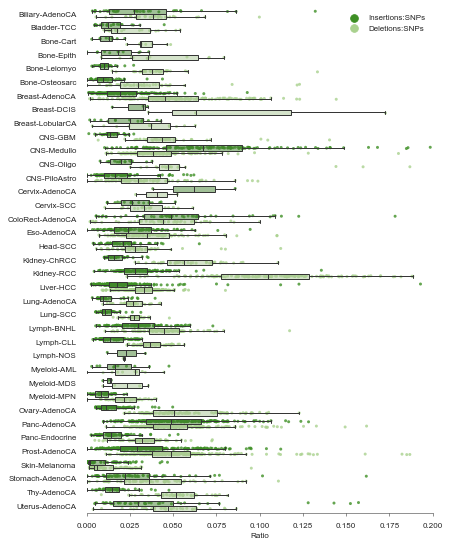

In [14]:
fig, ax = plt.subplots(figsize=(linewidth, linewidth*1.5))

bp_order = list(sorted(set(list(df["tumour_type"]))))
pal = sns.color_palette("colorblind", 2)
pal=[my_orange,my_blue]
flierprops = dict(marker='o', markersize=3)

black_pal = ["black", "black"]

sns.stripplot(y="tumour_type", x="value",hue="variable", data=df,
           order=bp_order, palette=cus_pal,dodge=True,
             alpha=.8,zorder=0, label=None, size=3,
             ax=ax)
sns.boxplot(y="tumour_type", x="value",hue="variable", data=df,
           order=bp_order, palette=cus_pal, showfliers=False, linewidth=1,
           ax=ax)#, flierprops=flierprops)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    #artist.set_facecolor('None')
    r, g, b, a = artist.get_facecolor()
    artist.set_facecolor((r, g, b, .5))
    # artist.set_edgecolor(col)

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    # for j in range(i*5,i*5+5):
    #     line = ax.lines[j]
    #     line.set_color(col)
    #     line.set_mfc(col)
    #     line.set_mec(col)


# for patch in ax[1].artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .75))


ax.legend(title=False)

handles, labels = ax.get_legend_handles_labels()

l = ax.legend(handles[2:], labels[2:])

for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')
    legpatch.set_linewidth(2)

ax.tick_params(bottom=True, left=False,
                  axis="both",
                  length=3,
                  width=border_width)

# plt.tick_params(axis='both', which='minor')
# plt.tick_params(axis='both', which='major')
ax.set_xlim(0,0.2)
#plt.legend(title=False, fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("Ratio")

sns.despine(left=True)

# plt.savefig("indel_to_snp_ratios.pdf",
#             format="pdf",
#             facecolor="white",
#             bbox_inches="tight")

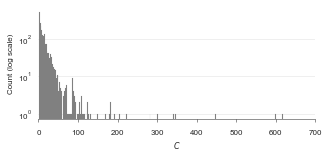

In [15]:
# plot values of C
with open("data/cluster_counts_no_zero.txt", "r") as f:
    c_vals = [int(i.strip()) for i in f.readlines()]

fig, ax = plt.subplots(figsize=(linewidth/1.25, linewidth/3))

sns.histplot(c_vals, color="grey", edgecolor="grey",alpha=1)

ax.tick_params(bottom=True,
                axis="x",
                length=3,
                width=border_width)
ax.tick_params(bottom=True,
                axis="y",
                length=0,
                which="both",
                width=border_width)
ax.set_axisbelow(True)
sns.despine(left=True)
ax.set_xlabel("$\it{C}$")
ax.set_ylabel("Count (log scale)")
ax.yaxis.grid(color="#e0e0e0",
                 linewidth=border_width)

ax.set_xlim(0,700)

ax.set_yscale("log")
#ax.set_ylim(top=1000)


# plt.savefig(fname="figures/C_parameter_values.pdf",
#             format="pdf",
#             bbox_inches="tight")

In [16]:
deletion_arrays, insertion_arrays = [], []

with open("testing_parameters/deletion_lengths.csv", "r") as f:
    for line in f.readlines():
        # if indels found, pass
        try:
            line = [int(i) for i in line.strip().split(",")]
        except:
            pass
        deletion_arrays.append(line)

with open("testing_parameters/insertion_lengths.csv", "r") as f:
    for line in f.readlines():
        # if indels found, pass
        try:
            line = [int(i) for i in line.strip().split(",")]
        except:
            pass
        insertion_arrays.append(line)

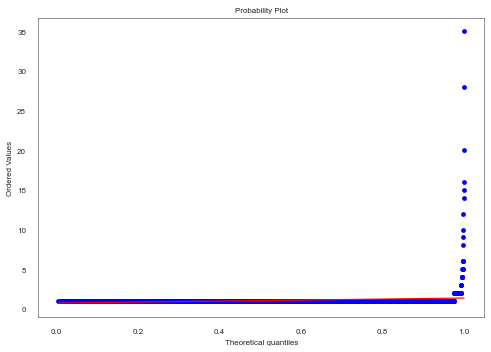

In [28]:
# inspecting probability plots of indel lengths

test_ins = insertion_arrays[10]
a = stats.probplot(test_ins, dist="powerlaw", sparams=(1.5), plot=pylab)

In [29]:
indel_len_df = indel_df[['mean_ins_len','mean_del_len','tumour_type']]
df = indel_len_df.melt()
tum_vals = list(df[df["variable"] == "tumour_type"]["value"]) * 2
df = df[df["variable"] != "tumour_type"]
df["tumour_type"] = tum_vals
df['value'] = df['value'].astype(float)
df = df.replace("mean_ins_len", "Insertions")
df = df.replace("mean_del_len", "Deletions")

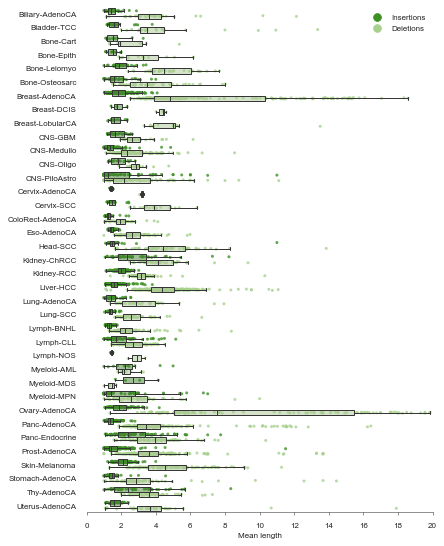

In [30]:
fig,ax = plt.subplots(figsize=(linewidth,linewidth*1.5))

bp_order = list(sorted(set(list(df["tumour_type"]))))
pal = sns.color_palette("colorblind", 2)
pal=[my_orange,my_blue]
flierprops = dict(marker='o', markersize=5)

sns.stripplot(y="tumour_type", x="value",hue="variable", data=df,
          order=bp_order, palette=cus_pal,dodge=True,
            alpha=.8,zorder=0, label=None,size=3,
            ax=ax)
sns.boxplot(y="tumour_type", x="value",hue="variable", data=df,
           order=bp_order, palette=cus_pal,showfliers=False,linewidth=1,
           ax=ax)#, flierprops=flierprops)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    #artist.set_facecolor('None')
    r, g, b, a = artist.get_facecolor()
    artist.set_facecolor((r, g, b, .5))

# for i,artist in enumerate(ax.artists):
#     col = artist.get_facecolor()
#     artist.set_edgecolor(col)
#     artist.set_facecolor('None')
#     for j in range(i*5,i*5+5):
#         line = ax.lines[j]
#         line.set_color(col)
#         line.set_mfc(col)
#         line.set_mec(col)

ax.legend(title=False)

handles, labels = ax.get_legend_handles_labels()

l = ax.legend(handles[2:], labels[2:])

for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')
    legpatch.set_linewidth(2)
    

ax.tick_params(bottom=True, left=False,
                  axis="both",
                  length=3,
                  width=border_width)

ax.set_xlim(0,20)
ax.xaxis.set_ticks(np.arange(0, 21, 2))

# ax.xaxis.grid(color="#e0e0e0",
#             linewidth=border_width)

ax.set_ylabel("")
ax.set_xlabel("Mean length")

sns.despine(left=True)

# plt.savefig("indel_lengths.pdf",
#             format="pdf", facecolor="white",
#             bbox_inches="tight")

No handles with labels found to put in legend.


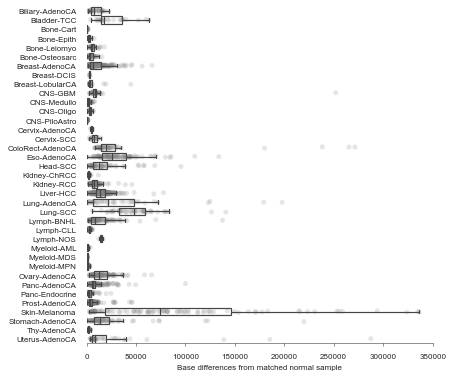

In [31]:
fig,ax = plt.subplots(figsize=(linewidth,linewidth))

bp_order = list(sorted(set(list(df["tumour_type"]))))
pal = sns.color_palette("colorblind", 2)
pal=[my_orange,my_blue]
flierprops = dict(marker='o', markersize=5)

sns.stripplot(y="tumour_type", x="base_diffs", data=indel_df,
           order=bp_order, alpha=.2,zorder=0, label="",
             color="grey",ax=ax)
sns.boxplot(y="tumour_type", x="base_diffs",data=indel_df,
           order=bp_order, showfliers=False,ax=ax)#, flierprops=flierprops)

for i,artist in enumerate(ax.artists):
    col = artist.get_facecolor()
  #  artist.set_edgecolor(col)
    artist.set_facecolor('None')
#     for j in range(i*5,i*5+5):
#         line = ax.lines[j]
#         line.set_color(col)
#         line.set_mfc(col)
#         line.set_mec(col)

ax.legend(title=False)

for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')
    legpatch.set_linewidth(2)
    
ax.tick_params(bottom=True, left=False,
                  axis="both",
                  length=3,
                  width=border_width)

ax.set_xlim(0,350000)
ax.set_ylabel("")
ax.set_xlabel("Base differences from matched normal sample")
sns.despine(left=True)

# ax.set_xscale("log")

# plt.savefig("base_differences_per_histology.pdf",
#             format="pdf",
#             facecolor="white",
#             bbox_inches="tight")

In [32]:
with open("data/samples_with_clusters.txt", "r") as f:
    samples=[i.strip() for i in f.readlines()]
    
cols = ["sample", "divergence", "ts_n_clusters", "indel_length", "indel_ratio", "event_count",
        "LPR", "frag_len", "mean_insertions", "mean_deletions",
        "mean_snps"]

var_dic = {}
var_list = []
LPRs = []

heads = ['sample',
 'snp_count',
 'mean_ins_lan',
 'mean_del_len',
 'ins_to_snp',
 'del_to_snp',
 'tumour_type',
 'del_sums',
 'ins_sums',
 'base_diffs',
 'indel_ratio',
 'event_count',
 'event_variance',
 'event_std','mean_ins','mean_del','mean_snps','mean_temp_ins',
        'event_var_normalised','event_std_normalised',
        'min_event', 'max_event', "lpr"]

for s in samples:
    samp_df = pd.read_csv("data/counted_events/" + s + ".tsv",
               sep="\t",header=None, names=cols)
    
    samp_df = samp_df[samp_df.indel_length != 1]
    
    LPRs.append(list(samp_df["LPR"]))
    event_arr = np.asarray(samp_df["event_count"])
    ins_arr = np.asarray(samp_df["mean_insertions"])
    del_arr = np.asarray(samp_df["mean_deletions"])
    snp_arr = np.asarray(samp_df["mean_snps"])
    temp_ins_arr = np.asarray(samp_df["frag_len"])

    if np.mean(event_arr) == 0.0:
        continue    

    snp_count = list(indel_df[indel_df["sample"] == s]["snp_count"])[0]
    ins_len = list(indel_df[indel_df["sample"] == s]["mean_ins_len"])[0]
    del_len = list(indel_df[indel_df["sample"] == s]["mean_del_len"])[0]
    ins_snp = list(indel_df[indel_df["sample"] == s]["ins_to_snp"])[0]
    del_snp = list(indel_df[indel_df["sample"] == s]["del_to_snp"])[0]
    tumour_type = list(indel_df[indel_df["sample"] == s]["tumour_type"])[0]
    del_sums = list(indel_df[indel_df["sample"] == s]["del_sums"])[0]
    ins_sums = list(indel_df[indel_df["sample"] == s]["ins_sums"])[0]
    base_diffs = list(indel_df[indel_df["sample"] == s]["base_diffs"])[0]
    indel_snp = list(indel_df[indel_df["sample"] == s]["indel_ratio"])[0]
    event_count = np.nanmean(event_arr)
    event_variance = np.nanvar(event_arr)
    event_std = np.nanstd(event_arr)
    
    ins_var = np.nanmean(ins_arr)
    del_var = np.nanmean(del_arr)
    snp_var = np.nanmean(snp_arr)
    temp_ins_var = np.nanmean(temp_ins_arr)
    
    mean_lpr = np.nanmean(samp_df["LPR"])

    min_event = event_arr.min()
    max_event = event_arr.max()

    var_normalised = event_variance / event_count
    std_normalised = event_std / event_count

    var_list.append([s,snp_count,ins_len,del_len,ins_snp,del_snp,tumour_type,del_sums,ins_sums,
    base_diffs,indel_snp,event_count,event_variance,event_std,
                    ins_var,del_var,snp_var,temp_ins_var,var_normalised,
                    std_normalised, min_event, max_event, mean_lpr])

df = pd.DataFrame(var_list, columns=heads)

In [33]:
flat_LPRs = np.asarray([item for sublist in LPRs for item in sublist])
flat_LPRs = flat_LPRs[~np.isnan(flat_LPRs)]

In [34]:
num_features = ['snp_count',
 'mean_ins_len',
 'mean_del_len',
 'ins_to_snp',
 'del_to_snp',
 'del_sums',
 'ins_sums',
 'base_diffs',
 'indel_ratio']

cat_features = ['tumour_type']

In [35]:
df_dic = {}

for k,v in tum_type_dic.items():
    tumour_samps = []
    for i in plt_labels:
        if i in v:
            tumour_samps.append(i)
    if len(tumour_samps) == 0:
        continue
    ts_indices = []
    for ts in tumour_samps:
        ts_indices.append([i for i, x in enumerate(plt_labels) if x == ts][0])
    ts_variance = []
    ts_mean_count = []
    for ts_i in ts_indices:
        ts_variance.append(plt_variance_vals[ts_i])
        ts_mean_count.append(plt_count_vals[ts_i])
    #print(k, ts_mean_count, ts_variance)
    tmp_df = pd.DataFrame([ts_mean_count, ts_variance]).T
    tmp_df.columns = ["mean_count", "variance"]
    df_dic[k] = tmp_df

NameError: name 'plt_labels' is not defined

In [ ]:
plt_labels = list(var_dic.keys())
plt_variance_vals = df["event_variance"]
plt_std_vals = df["event_std"]
plt_count_vals = df["event_count"]
plt_tumour_types = df["tumour_type"]

plt_min_vals = df["min_event"]
plt_max_vals = df["max_event"]

sorted_counts = [x for _,x in sorted(zip(plt_std_vals,plt_count_vals))]
sorted_tumours = [x for _,x in sorted(zip(plt_std_vals,plt_tumour_types))]
sorted_stds = sorted(plt_std_vals)
sorted_min = sorted(plt_min_vals)
sorted_max = sorted(plt_max_vals)

In [37]:
# tst_df = df[df["tumour_type"] == "Skin-Melanoma"]
# tst_df[tst_df["event_std_normalised"] >= 10]

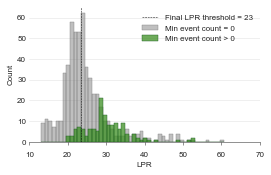

In [36]:
min_event_zero_lpr = df[df["min_event"]==0]["lpr"]
min_event_gt_zero_lpr = df[df["min_event"]>0]["lpr"]

bins = np.histogram_bin_edges(min_event_zero_lpr, bins=50)

fig, ax = plt.subplots(figsize=(linewidth/1.5, linewidth/2.5))

sns.histplot(min_event_zero_lpr, color="grey", alpha=.5,bins=bins,
             label="Min event count = 0",ax=ax, edgecolor="grey")
sns.histplot(min_event_gt_zero_lpr, color=ts_green, alpha=.75,bins=bins,
             label="Min event count > 0",ax=ax, edgecolor="#1B5E20")


sns.despine(left=True)

ax.grid(axis="y", color="#e0e0e0", linewidth=border_width)

ax.tick_params(axis='y',
               which='both',
               length=0,
               width=border_width,
               pad=3)

ax.tick_params(axis='x',
               bottom=True,
               which='both',
               length=3,
               width=border_width)

ax.set_xlim(10,70)

ax.set_xlabel("LPR")


ax.axvline(23.4,linestyle="dashed", color="black", linewidth=border_width,
           label="Final LPR threshold = 23")

ax.legend()

# plt.savefig("LPR_min_event_count_diff.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

In [38]:
cancer_event_df = pd.read_csv("final_output/cancer_events.both.sorted.no_repeats.csv",
                              header=None,
                              names=["histology"] + df_headers)
cancer_event_df["length"] = (cancer_event_df["sp2_ref"] - cancer_event_df["sp3_ref"])+1

cancer_event_df = cancer_event_df.sort_values(by=["histology"], ascending=True)

In [39]:
tumour_axis_label_positions = {}
sorted_tumours = list(cancer_event_df["histology"])

for i in set(sorted_tumours):
    first_pos = sorted_tumours.index(i)
    last_pos = (len(sorted_tumours) - sorted_tumours[::-1].index(i)) - 1
    tumour_axis_label_positions[((first_pos + last_pos) / 2)] = i

In [40]:
colour_dic = {
    '①-④-③-②,\n③-②-①-④':"#051e7f",
    '①-③-②-④':"#00796b",
    '③-①-②-④,\n①-③-④-②':"#97bfff",
    '③-①-④-②':"#ad1457"
}

def determine_point_ordering(swp):
    points = [1,2,3,4]
    return "".join([str(x) for _,x in sorted(zip([int(i) for i in swp],points))])

rearrangement_type_dic = {
    "1432":"①-④-③-②,\n③-②-①-④",
    "3214":"①-④-③-②,\n③-②-①-④",
    "3124":"③-①-②-④,\n①-③-④-②",
    "1342":"③-①-②-④,\n①-③-④-②",
    "3241":"③-②-④-①,\n④-①-③-②",
    "4132":"③-②-④-①,\n④-①-③-②",
    "1324":"①-③-②-④",
    "3142":"③-①-④-②",
    "3412":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "3421":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "4312":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "4321":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
}

point_orders = []
grouped_point_orders = []

for row in cancer_event_df.iterrows():
    row = row[1]
    p = [row["sp1_ref"],row["sp2_ref"],row["sp3_ref"],row["sp4_ref"]]
    p_order = determine_point_ordering(p)
    point_orders.append(p_order)
    try:
        grouped_point_orders.append(rearrangement_type_dic[p_order])
    except:
        print(p_order, list(row))

cancer_event_df["point_orders"] = point_orders
cancer_event_df["grouped_point_orders"] = grouped_point_orders

In [41]:
et_1, et_3, et_2 = list(set(cancer_event_df["grouped_point_orders"]))

et1, et2, et3 = np.zeros(15),np.zeros(15),np.zeros(15)

et_df = cancer_event_df[cancer_event_df["grouped_point_orders"] == et_1]
for i in range(4,len(et1)+4):
    et1[i-4] = len(et_df[et_df["length"] == i])

et_df = cancer_event_df[cancer_event_df["grouped_point_orders"] == et_2]
for i in range(4,len(et2)+4):
    et2[i-4] = len(et_df[et_df["length"] == i])

et_df = cancer_event_df[cancer_event_df["grouped_point_orders"] == et_3]
for i in range(4,len(et3)+4):
    et3[i-4] = len(et_df[et_df["length"] == i])

bar_labels=list(range(4,len(et1)+4))
width = 0.35

In [42]:
bds = []
for i in cancer_event_df["sample"]:
    bds.append(int(indel_df[indel_df["sample"] == i]["base_diffs"]))

cancer_event_df["base_diffs"] = bds
cancer_event_df["count"] = 1

cancer_merged_sample_df = cancer_event_df.groupby(["histology", "sample", "base_diffs"])["count"].count().reset_index()

([<matplotlib.patches.Wedge at 0x7fc669605b20>,
 [Text(1.0601536723749838, 0.2933840332223882, '8.6%'),
  Text(0.7184901272491546, 0.832929731157133, '10.2%'),
  Text(-0.9146165735328001, -0.6111272563215622, '81.2%')])

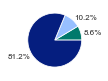

In [43]:
labels, pie_n, pie_colours = [], [], []

fig, ax = plt.subplots(figsize=(linewidth/5, linewidth/5))

for hist in cancer_event_df["grouped_point_orders"].unique():
    len_app = len(cancer_event_df[cancer_event_df["grouped_point_orders"] == hist])
    pie_n.append(len_app)
    labels.append(str(round(len_app / len(cancer_event_df) * 100, 1)) + "%")
    pie_colours.append(colour_dic[hist])

plt.pie(pie_n, colors=pie_colours, labels=labels)

# plt.savefig("total_event_type_pie.pdf",
#              format="pdf",
#              bbox_inches="tight",
#              facecolor="white")

In [44]:
# cancer_merged_sample_df
print("10% histologies:")
for i in sorted(cancer_merged_sample_df["histology"].unique()):
    total_df_len = len(indel_df[indel_df["tumour_type"] == i])
    sub_df = cancer_merged_sample_df[cancer_merged_sample_df["histology"] == i].sort_values("base_diffs")
    if (len(sub_df)/total_df_len) > 0.1:
        print(i)

print("")

print("More than 1 per sample histologies:")
for i in sorted(cancer_merged_sample_df["histology"].unique()):
    total_df_len = len(indel_df[indel_df["tumour_type"] == i])
    sub_df = cancer_merged_sample_df[cancer_merged_sample_df["histology"] == i].sort_values("base_diffs")
    if (max(sub_df["count"])) > 1:
        print(i)

10% histologies:
Bladder-TCC
Lymph-BNHL

More than 1 per sample histologies:
Breast-AdenoCA
Lung-SCC
Lymph-BNHL
Panc-AdenoCA
Prost-AdenoCA


In [45]:
len(cancer_event_df["sample"].unique())

120

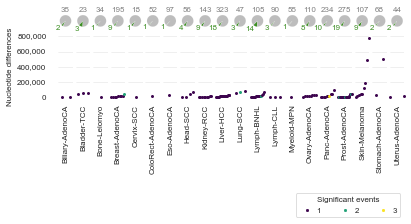

In [46]:
fig, ax = plt.subplots(2,20,figsize=(linewidth, linewidth/4), gridspec_kw={'height_ratios': [1, 4]})

ax_i = 0

palette = {1:"#3d054e", 2:"#21a177", 3:"#f9e31f"}


for i in sorted(cancer_merged_sample_df["histology"].unique()):
    sub_df = cancer_merged_sample_df[cancer_merged_sample_df["histology"] == i].sort_values("base_diffs")

    total_df_len = len(indel_df[indel_df["tumour_type"] == i])

    sns.stripplot(data=sub_df, y="base_diffs", x="sample", ax=ax[1][ax_i],hue="count",size=3,palette=palette,alpha=1,linewidth=0,clip_on=False,zorder=10)

    #plt.pie([len(sub_df), total_df_len], ax=ax[0][ax_i])
    patches, texts = ax[0][ax_i].pie([len(sub_df), total_df_len],
                                           colors=[ts_green,grey],
                                           wedgeprops = {'linewidth': .1},
                                           textprops={'fontsize': 8},
                                           labels=[len(sub_df), ""],
                                           startangle=225,
                                           labeldistance=1.5)

    for ip, patch in enumerate(patches):
        texts[ip].set_color(patch.get_facecolor())
    
    ax[0][ax_i].set_title(total_df_len, color="grey", fontsize=8, pad=1.5)

    ax[1][ax_i].set_yticks([0,200000,400000,600000,800000])

    if ax_i != 0:
        ax[1][ax_i].set_ylabel("")
        ax[1][ax_i].set_yticklabels([])
        # ax[1][ax_i].set_yticklabels([])
    else:
        ax[0][0].set

        ax[1][0].set_ylabel("Nucleotide differences")
        ax[1][ax_i].set_yticklabels(["0","200,000","400,000","600,000","800,000"])
        #ax[0].set_yticklabels([0,100000,200000,300000,400000,500000,600000,700000,800000])
    ax[1][ax_i].set_xlabel(i, rotation=90)
    ax[1][ax_i].set_xticklabels([])

    ax[1][ax_i].set_ylim(0,800000)

    #if i != "Panc-AdenoCA":
    ax[1][ax_i].get_legend().remove()

    ax[1][ax_i].tick_params(axis='x', which='both',
                         length=0, width=border_width, pad=3)

    ax[1][ax_i].grid(axis="y", color="#e0e0e0", linewidth=border_width)

    ax_i += 1

# handles, labels = ax[:].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')


# plt.legend( handles=sp_list,loc="upper left", bbox_to_anchor=[0, 1],
#            ncol=2, shadow=True, title="Legend", fancybox=True)

#plt.legend()
handles = []

for i in palette.keys():
    handles.append(plt.scatter([],[], color=palette[i], s=5, label=i))

leg = plt.legend(handles=handles, frameon=True, bbox_to_anchor=(1, -1.5),
           title="Significant events", ncol=3, handletextpad=.2)

# leg._legend_box.align = "left"

sns.despine(left=True,bottom=True)

#plt.subplots_adjust(wspace=0)
#fig.tight_layout()

# plt.savefig("cancer_sig_events_found_by_divergence.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

In [48]:
hist_n = []

for hist in cancer_event_df["histology"].unique():
    len_app = len(cancer_event_df[cancer_event_df["histology"] == hist])
    for i in range(len_app):
        hist_n.append(hist + " (n={})".format(len_app))

cancer_event_df["hist_n"] = hist_n

In [12]:
np.median(cancer_event_df["length"])
stats.median_absolute_deviation(cancer_event_df["length"])

<ipython-input-12-2bc1eccefe23>:3: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  stats.median_absolute_deviation(cancer_event_df["length"])


1.4826

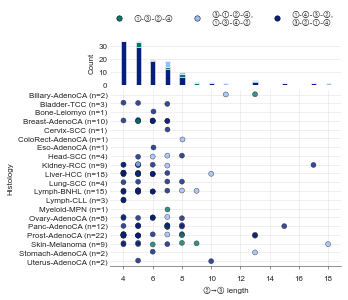

In [49]:
fig, ax = plt.subplots(2,1,figsize=(linewidth/1.5,linewidth/1.5),
                       sharex=True,
                       gridspec_kw={'height_ratios': [1,4]})

fpath= "/System/Library/Fonts/Supplemental/Arial Unicode.ttf"
prop = matplotlib.font_manager.FontProperties(fname=fpath)

colour_dic = {
    '①-④-③-②,\n③-②-①-④':"#051e7f",
    '①-③-②-④':"#00796b",
    '③-①-②-④,\n①-③-④-②':"#97bfff",
    '③-①-④-②':"#ad1457"
}

ax[0].bar(bar_labels, et1, width, color=colour_dic[et_1], linewidth=border_width)
ax[0].bar(bar_labels, et2, width, bottom=et1, color=colour_dic[et_2], linewidth=border_width)
ax[0].bar(bar_labels, et3, width, bottom=et2+et1, color=colour_dic[et_3], linewidth=border_width)

ax[0].set_yticks([0,10,20,30]) 
#ax[0].set_xticklabels(n_xticks[0])

sns.despine(left=True,bottom=True,ax=ax[0])
ax[0].tick_params(axis='y',
               which='both',
               length=0,
               width=border_width,
               pad=3)

ax[0].yaxis.grid(color="#e0e0e0",
                linewidth=border_width)

ax[0].set_ylabel("Count")

# ax[1].tick_params(axis='x',
#                bottom=True,
#                which='both',
#                length=3,
#                width=border_width)

sns.stripplot(data=cancer_event_df, y="hist_n", x="length",
              dodge=False,
              jitter=True, hue="grouped_point_orders", palette=colour_dic,
              alpha=.8,linewidth=.5,ax=ax[1]
              )

# sns.boxplot(showmeans=True,
#             meanline=True,
#             meanprops={'color': 'k', 'ls': '-', 'lw': border_width},
#             medianprops={'visible': False},
#             whiskerprops={'visible': False},
#             zorder=10,
#             x="length",
#             y="histology",
#             data=cancer_event_df,
#             showfliers=False,
#             showbox=False,
#             showcaps=False,
#             ax=ax)
handles, ha_labels = ax[1].get_legend_handles_labels()
for ha in handles:
    ha.set_edgecolor("black")
    ha.set_linewidth(.5)
ax[1].legend(prop=prop, markerscale=.7,bbox_to_anchor=(1, 1.5),ncol=3)

sns.despine(left=True,ax=ax[1])

#ax.grid(axis="y", color="#e0e0e0", linewidth=border_width)

ax[1].tick_params(axis='y',
               which='both',
               length=0,
               width=border_width,
               pad=3)

ax[1].tick_params(axis='x',
               bottom=True,
               which='both',
               length=3,
               width=border_width)

ax[1].grid(color="#e0e0e0",
                linewidth=border_width)


ax[1].set_ylabel("Histology")
ax[1].set_xlabel("{}→{} length".format(circled(2), circled(3)), font=prop)

plt.subplots_adjust(hspace=0.05)

plt.savefig("cancer_event_summary.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

# ax.set_yticks(list(tumour_axis_label_positions.keys()))
# ax.set_yticklabels(list(tumour_axis_label_positions.values()))

In [50]:
cancer_event_df["length"].median()
stats.median_abs_deviation(cancer_event_df["length"])
cancer_event_df["length"].max()

18

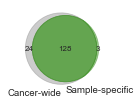

In [51]:
fig, ax = plt.subplots(figsize=(linewidth/4, linewidth/4))

v = venn2(subsets = (24, 3, 128),
      set_labels = ('Cancer-wide', 'Sample-specific'),
      ax=ax
      )
v.get_patch_by_id('100').set_color('grey')
v.get_patch_by_id('010').set_color(ts_green)
v.get_patch_by_id('010').set_alpha(0.5)

v.get_patch_by_id('110').set_color(ts_green)
v.get_patch_by_id('110').set_alpha(0.8)

# plt.savefig("parameter_venn.pdf",
#              format="pdf",
#              bbox_inches="tight",
#              facecolor="white")

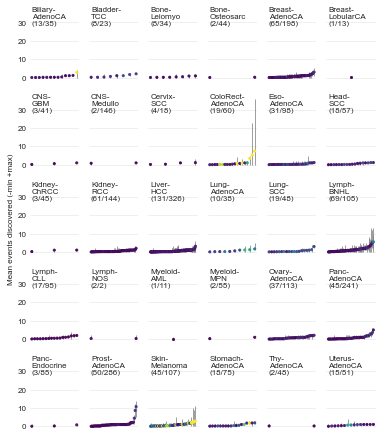

In [53]:
df_sorted = df.sort_values(by=["tumour_type", "event_count"])

set_tum_types = sorted(set(df["tumour_type"]))

fig, ax = plt.subplots(5,6,figsize=(linewidth,linewidth*1.25),
                      sharey=True)

ax_count = 0
row_count = 0
fs = 20
norm = colors.Normalize(0,300000)

for tt in set_tum_types:
    if row_count % 6 == 0 and row_count != 0:
        ax_count += 1
        row_count = 0
    subset_df = df_sorted[df_sorted["tumour_type"] == tt]
    plt_variance_vals = subset_df["event_variance"]
    plt_std_vals = subset_df["event_std"]
    plt_count_vals = subset_df["event_count"]
    plt_tumour_types = subset_df["tumour_type"]
    plt_base_diffs = subset_df["base_diffs"]
    plt_min_vals = subset_df["min_event"]
    plt_max_vals = subset_df["max_event"]

    color_var = plt_base_diffs
    cm = plt.cm.get_cmap('viridis')
    col_list = []
    upper_color=300000
    for i in list(color_var):
        if i > upper_color:
            col_list.append(upper_color)
        else:
            col_list.append(i)
    color_var = col_list
    my_cm = cm(color_var)
    scatter_plot = ax[ax_count][row_count].scatter(y=plt_count_vals,
                                        x=np.arange(len(plt_count_vals)),
                                        c=color_var,
                                        cmap=cm,
                                        norm=norm,
                                        s=5,
                                        zorder=5,
                                        clip_on=False)


    ax[ax_count][row_count].errorbar(y=plt_count_vals,
                 x=np.arange(len(plt_count_vals)),
                 yerr=(plt_count_vals-plt_min_vals,plt_max_vals-plt_count_vals),
                 fmt='-',
                 ls='none', elinewidth=.75,
                 zorder=1, color="grey")

    # ax[ax_count][row_count].errorbar(y=plt_count_vals,
    #              x=np.arange(len(plt_count_vals)),
    #              yerr=plt_std,
    #              fmt='-',
    #              ls='none', elinewidth=.75,
    #              zorder=1, color="grey")

    tt_title = tt.split("-")
    tt_title = tt_title[0] + "-\n" + tt_title[1]

    # ax[ax_count][row_count].set_title("{0}".format(tt_title))

    ax[ax_count][row_count].tick_params(axis='x', which='major', labelsize=0)
    #ax[ax_count][row_count].tick_params(axis='y', which='major', labelsize=fs)
    ax[ax_count][row_count].tick_params(axis='y', which='both',
                                        length=0, width=border_width,pad=3)
    # plt.style.use("seaborn-white")
    # sns.set_style("white")
    
    ax[ax_count][row_count].grid(axis="y", color="#e0e0e0", linewidth=border_width)
#     if row_count != 0:
#         ax[ax_count][row_count].set_yticklabels([])
    # if row_count == 0:
    #     ax[ax_count][row_count].tick_params(axis='both', which='major')
    if ax_count == 2 and row_count == 0:
        ax[ax_count][row_count].set_ylabel("Mean events discovered (-min +max)")
    ax[ax_count][row_count].set_xlabel("")
    ax[ax_count][row_count].set_xticklabels([])

    ax[ax_count][row_count].annotate("{0}\n({1}/{2})".format(tt_title, len(subset_df),
                                                      tumour_type_count_dic[tt]),
                                     xy=(0, 1),
                                     xycoords='axes fraction',
                                     xytext=(2, 1.5),
                                     textcoords='offset points',
                                     horizontalalignment='left',
                                     verticalalignment='top')


    #ax[ax_count][row_count].set_xticks(list(tumour_axis_label_positions.keys()))
    #ax[ax_count][row_count].set_xticklabels(list(tumour_axis_label_positions.values()),
    #                             fontsize=fs,
    #                            rotation=90)
    row_count += 1
if row_count % 6 == 0 and row_count != 0:
    ax_count += 1
    row_count = 0
sns.despine(bottom=True, left=True)
# ax[ax_count][row_count].set_xticklabels([])
#ax[ax_count][row_count].set_title('Base differences', fontsize=fs)
# ax[ax_count][row_count].tick_params(axis='y', which='both',
#                                     length=3, width=border_width)
#ax[ax_count][row_count].tick_params(axis='y', which='major')
# ax[ax_count][row_count].set_ylabel("Base differences")

    # ax[ax_n][1].tick_params(bottom=True,
    #                 left=True,
    #                 axis="y",
    #                 length=3,
    #                 which="both",
    #                 width=border_width)

# cbar = fig.colorbar(scatter_plot, ax=ax[ax_count][row_count:row_count+3],
#                     orientation="horizontal",
#                     aspect=50)
# ## cbar.set_title("Base differences",fontsize=fs)
# # cbar.tick_params(labelsize=20)
# cbar.outline.set_visible(False)

# cbar.set_ticks([0,50000,100000,150000,200000,250000,300000])
# cbar.set_ticklabels([0,"$\mathdefault{5×10^4}$",
#                      "$\mathdefault{1×10^5}$",
#                      "$\mathdefault{1.5×10^5}$",
#                      "$\mathdefault{2×10^5}$",
#                      "$\mathdefault{2.5×10^5}$",
#                      "$\mathdefault{\geq3×10^5}$"])

# cbar.ax.tick_params(labelsize=7)


# plt.subplots_adjust(wspace=0.25, hspace=0.25)

#plt.legend(loc="lower left")

#plt.yscale("log")


# plt.savefig("events_discovered_across_parameters_base_diff_color_grid_nocbar.pdf",
#             format="pdf",
#             facecolor="white",
#             bbox_inches="tight")

In [55]:
interest_col_names = [
    "sample",
    "divergence",
    "ts_n_clusters",
    "indel_length",
    "indel_snp_ratio",
    "events_found",
    "mean_lpr",
    "mean_23_len",
    "mean_clus_ins",
    "mean_clus_del",
    "mean_clus_snps",
    "param_set"
]

true_vs_tested_df = pd.read_csv("data/true_vs_tested_samples_of_interest_dropped.tsv",
                                delimiter="\t",
                                header=None,
                                names=interest_col_names)

true_vs_tested_df_full = pd.read_csv("data/true_vs_tested_samples_of_interest.tsv",
                                delimiter="\t",
                                header=None,
                                names=interest_col_names)

In [56]:
list(set(true_vs_tested_df["sample"]))

name_dic = {
 '0d569bd5-418d-4d72-87ca-8e14668c2119': "Lymph-BNHL-1 (13)",
 '14c5b81d-da49-4db1-9834-77711c2b1d38': "ColoRect-AdenoCA-2 (23)",
 'deb9fbb6-656b-41ce-8299-554efc2379bd': "Skin-Melanoma-1 (11)",
 '04aa6b77-8074-480c-872e-a1a47afa5314': "Skin-Melanoma-2 (10)",
 '2df02f2b-9f1c-4249-b3b4-b03079cd97d9': "ColoRect-AdenoCA-1 (36)",
 'f9dc999f-6dde-448d-9cf1-2897ddcf7b0b': "Lymph-BNHL-2 (13)",
 "test": "Test parameter value",
 "sample": "Sample-specific parameter value"
}

true_vs_tested_df = true_vs_tested_df.replace(name_dic)

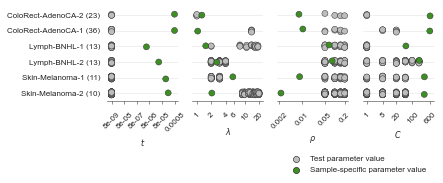

In [57]:
fig, ax = plt.subplots(1,4,figsize=(linewidth, linewidth/2))

palette=[grey, ts_green]
n=-1

xlabs = {"divergence": "$\it{t}$",
         "indel_length": "$\it{λ}$",
         "indel_snp_ratio": "$\it{ρ}$",
         "ts_n_clusters": "$\it{C}$"}

div_ticks = [0.0008, 0.00008, 0.000008, 0.0000008, 0.00000008, 0.000000008]
lambda_ticks = [1,2,4,6,10,20]
rho_ticks = [0.002,0.01,0.05, 0.2]
c_ticks = [1,5,20,100,600]

n_xticks = {
  0: div_ticks,
  1: lambda_ticks,
  2: rho_ticks,
  3: c_ticks
}



div_labs = [r"$8×10^{-9}$", "$8×10^{-9}$", "$8×10^{-9}$", "$8×10^{-9}$", "$8×10^{-9}$", "$8×10^{-9}$"]
for x_var in ["divergence", "indel_length", "indel_snp_ratio","ts_n_clusters"]:
    n += 1
    sns.stripplot(y="sample", x=x_var,
                data=true_vs_tested_df,
                hue="param_set", jitter=True,
                size=6, linewidth=.5, alpha=1, dodge=False, 
                palette=palette,
                ax=ax[n])
    
    ax[n].set_ylabel("")
    if n != 0:
      ax[n].set_yticklabels([])

    ax[n].tick_params(bottom=True,
                    axis="x",
                    length=3,
                    which="major",
                    width=border_width)

    ax[n].tick_params(bottom=True,
                    axis="y",
                    pad=2,
                    which="major")

    ax[n].set_xlabel(xlabs[x_var])
    ax[n].set_xscale("log")

    ax[n].set_xticks(n_xticks[n]) 
    ax[n].set_xticklabels(n_xticks[n])
    ax[n].axes.tick_params(which="major", rotation=45, axis="x")
    
    ax[n].yaxis.grid(color="#e0e0e0",
                 linewidth=border_width)
    # ax[n].xaxis.grid(color="#e0e0e0",
    #              linewidth=border_width)
    if n != 3:
      ax[n].legend([],[], frameon=False)
    else:
      handles, labels = ax[n].get_legend_handles_labels()
      for ha in handles:
          ha.set_edgecolor("black")
          ha.set_linewidth(.5)
      lgnd = ax[n].legend(handles, labels, bbox_to_anchor=(1, -.5), ncol=1, markerscale=.8)
      # lgnd.legendHandles[0]._legmarker.set_markersize(6)
      # lgnd.legendHandles[1]._legmarker.set_markersize(6)
    if n == 0:
      ax[n].set_xlim(left=0.0000000035, right=0.0015)
      # ax[n].set_xticklabels(div_labs)
      #ax[n].ticklabel_format(style='plain')
      # ax[n].get_xaxis().set_major_formatter(
      #     matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x), ',')))

      # ax[n].xaxis.set_major_formatter(matplotlib.ticket.ScalarFormatter())
      # ax[n].xaxis.get_major_formatter().set_scientific(False)

    if n == 1:
      ax[n].set_xlim(left=0.8, right=24.5)
    if n == 2:
      ax[n].set_xlim(left=0.00175, right=0.26)
    if n == 3:
      ax[n].set_xlim(left=0.65, right=875)



fig.tight_layout()
sns.despine(left=True)

plt.subplots_adjust(wspace=.2)

#
#ax._legend.remove()
#ax.axes.tick_params(which="major", rotation=90)

#ax.legend([],[], frameon=False)

# plt.savefig("test_strip.pdf",
#             format="pdf",
#             bbox_inches="tight")